In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tqdm

import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler

In [2]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU') ) > 0

Python Platform: macOS-13.0.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.0.0
Scikit-Learn 1.2.2


In [ ]:
imputed_train_data = pd.read_csv(r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\datasets\imputed_dataset\lr_imputed_train.csv')
imputed_test_data = pd.read_csv(r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\datasets\imputed_dataset\lr_imputed_test.csv')
imputed_train_data

,url,age,num_suspicious_words,has_ip_address,is_url_shortened,length,subdomain_ratio,num_dots,num_www,num_dcom,...,num_semic,num_comma,login_time,num_ex_links,num_redirects,num_img,num_iframe,num_hidden,ext_tot_ratio,status
0,https://www.crossstitch.pk/,17.266665,0,0,0,27,0.666667,2,1,0,...,0,0,1.296597,247.0,1.0,95.0,1.0,1.0,247.0,0
1,http://www.wikiwand.com/en/LATAM_Chile,9.200000,0,0,0,38,0.421053,2,1,1,...,0,0,0.093795,91.0,1.0,3.0,0.0,1.0,91.0,0
2,http://www.iconmeals.com/,9.065753,0,0,0,25,0.680000,2,1,1,...,0,0,1.031102,105.0,1.0,20.0,0.0,1.0,105.0,0
3,http://calvaryepiscopalbatavia.org/wp-includes...,7.057534,1,0,0,68,0.397059,1,0,0,...,0,0,0.640474,0.0,0.0,0.0,0.0,0.0,0.0,1
4,www.sharpaviation.com.au/index.php/pt_home,27.353425,0,0,0,42,0.571429,4,1,1,...,0,0,5.873612,76.0,1.0,11.0,1.0,1.0,76.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14155,http://lbcpzonasegurabeta.rf.gd/,9.638965,0,0,0,32,0.750000,2,0,0,...,0,0,0.734203,0.0,0.0,0.0,0.0,0.0,0.0,1
14156,https://www.e-serviceparts.info/landingpages/d...,4.575342,0,0,0,125,0.184000,2,1,0,...,0,0,0.046956,0.0,0.0,0.0,0.0,0.0,0.0,1
14157,rzr.online.fr/resume.htm,14.227397,0,0,0,24,0.541667,3,0,0,...,0,0,1.753927,1.0,0.0,0.0,0.0,0.0,1.0,0
14158,en.wikipedia.org/wiki/Aldus_Corporation,22.191781,0,0,0,39,0.410256,2,0,0,...,0,0,0.298482,330.0,1.0,11.0,0.0,4.0,330.0,0


In [10]:
# Define input shapes
text_input_shape = (100,)
num_input_shape = (imputed_train_data.shape[1] - 2,)

# Tokenize textual data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, filters='', char_level=True)
tokenizer.fit_on_texts(''.join(imputed_train_data['url']))
vocab_size = len(tokenizer.word_index) + 1

# Textual data
text_train = pad_sequences(tokenizer.texts_to_sequences(imputed_train_data['url']), maxlen=text_input_shape[0], padding="post")
text_test = pad_sequences(tokenizer.texts_to_sequences(imputed_test_data['url']), maxlen=text_input_shape[0], padding="post")

# Numerical data
num_train = imputed_train_data.iloc[:, 1:(num_input_shape[0] + 1)].values
num_test = imputed_test_data.iloc[:, 1:(num_input_shape[0] + 1)].values

mean_sd_sc = StandardScaler()
num_train_std = mean_sd_sc.fit_transform(num_train)
num_test_std = mean_sd_sc.transform(num_test)

# Response
y_train = imputed_train_data.iloc[:, (num_input_shape[0] + 1)].values
y_test = imputed_test_data.iloc[:, (num_input_shape[0] + 1)].values.squeeze()

### Load the model

In [ ]:
cnn = tf.keras.models.load_model(r'C:\Users\irfan\OneDrive\Desktop\Deep-Learning-Phishing-Website-Detection-main\models\deep_learining\CNN.keras')

### Get the prediction of the test set for each model

In [ ]:
cnn_y_prob = cnn.predict([text_test, num_test_std]).squeeze()
cnn_y_pred = [1 if x > 0.5 else 0 for x in cnn_y_prob]


111/111 [==============================] - 0s 3ms/step


### Confusiona matrix

In [ ]:
def confusion_matrix_heatmap(y_true, y_pred, model=None):
    plt.figure(figsize=(8,8))
    sns.heatmap(confusion_matrix(y_true, y_pred),
                fmt='1',
                annot=True,
                cmap="Blues",
                xticklabels=['Predicted legitimate', 'Predicted phishing'],
                yticklabels=['Actual legitimate', 'Actual phishing'],
                annot_kws={"size": 14})
    if model != None:
        plt.title(f'Confusion matrix-{model}', {'fontsize':18})

### CNN

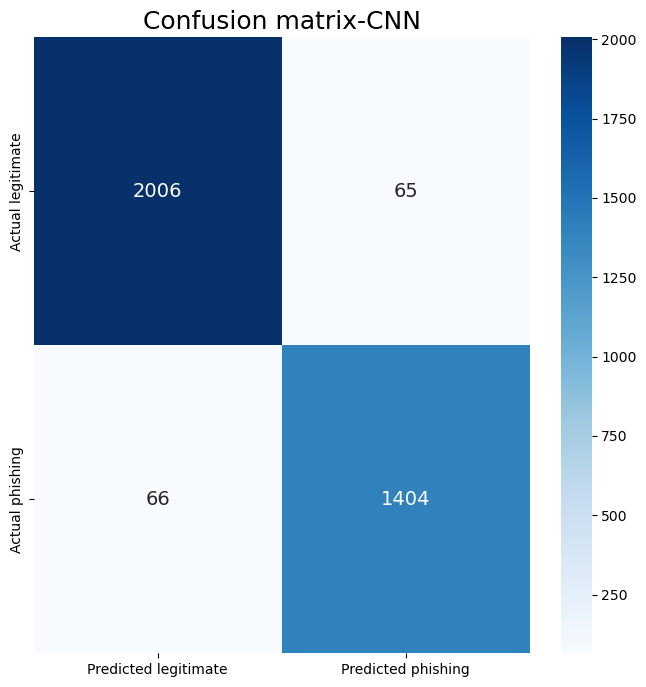

In [32]:
confusion_matrix_heatmap(y_test, cnn_y_pred, 'CNN')

In [33]:
# Print the metrics
print("Accuracy: %0.3f" % (accuracy_score(y_test, cnn_y_pred)))
print("Precision:%0.3f" % (f1_score(y_test, cnn_y_pred)))
print("Recall:%0.3f" % (precision_score(y_test, cnn_y_pred)))
print("F1-score:%0.3f" % (recall_score(y_test, cnn_y_pred)))

Accuracy: 0.963
Precision:0.955
Recall:0.956
F1-score:0.955
